In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as nla
import numpy.random as nrd
import matplotlib.pyplot as plt

# Exercise 6.12

Write a computer program to perform a local linear discriminant analysis. At each query point x0, the training data receive weights $K_{\lambda}(x0, xi)$ from a weighting kernel, and the ingredients for the linear decision boundaries (see Section 4.3) are computed by weighted averages.

Try out your program on the zipcode data, and show the training and test errors for a series of five pre-chosen values of λ.

# Solution

Let's load the training and test data

In [2]:
training_link = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz"
test_link = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz"

training_dataframe = pd.read_csv(training_link,sep=' ',header=None,usecols=range(257))
test_dataframe = pd.read_csv(test_link,sep=' ',header=None,usecols=range(257))

# Shuffling the rows
training_dataframe = training_dataframe.sample(frac=1)
test_dataframe = test_dataframe.sample(frac=1)

test_dataframe.tail()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
1006,0,-1.0,-1.0,-1.0,-1.0,-0.736,0.220,0.999,0.779,-0.764,...,0.000,-0.545,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0
928,2,-1.0,-1.0,-1.0,-1.0,-0.686,-0.168,0.238,0.645,0.855,...,0.118,0.843,1.000,1.000,0.957,0.484,-0.192,-0.994,-1.0,-1.0
1570,9,-1.0,-1.0,-1.0,-1.0,-1.000,-0.984,-0.398,0.416,0.988,...,0.591,0.719,-0.856,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0
526,8,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.853,-0.218,0.416,...,0.735,0.333,0.101,-0.756,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0
1955,0,-1.0,-1.0,-1.0,-1.0,-1.000,0.376,0.961,0.304,0.152,...,0.660,0.432,0.182,-0.739,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0


In [3]:
# The data have already been standardized (and is)

#Training
y_train = training_dataframe.pop(0).to_numpy()
X_train = training_dataframe.to_numpy()

#Test
y_test = test_dataframe.pop(0).to_numpy()
X_test = test_dataframe.to_numpy()

The Epanechnikov Kernel and the Gaussian Kernel

In [4]:
def kernel(x0,X,lam):
    
    norm = np.minimum(nla.norm(X-x0,axis=1)/lam,1)
    epanechnikov = 3*lam*(1-norm**2)/(2*(3-lam**2))
    
    return epanechnikov

def gauss_kernel(x0,X,lam):
    
    norm = nla.norm(X-x0,axis=1)
    gauss = np.exp(- norm**2 / (2*lam**2) ) / (np.sqrt(2*np.pi)*lam)
    
    return gauss

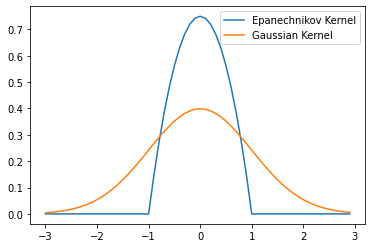

In [5]:
# Example of Epanechnikov and Gaussian kernel
x_line = np.arange(-3,3,0.1)
x_arr = x_line.reshape((x_line.size,1))
x0 = 0
lam = 1

wx1 = kernel(x0,x_arr,lam)
wx2 = gauss_kernel(x0,x_arr,lam)
plt.plot(x_line,wx1,label='Epanechnikov Kernel')
plt.plot(x_line,wx2,label='Gaussian Kernel')
plt.legend()
plt.show()

Local Linear Discriminant Analysis

In [6]:
def local_lda(x0,X,y,K):
    
    _,p = X.shape
    
    weights = K(x0,X)
    norm = np.sum(weights)
    
    mu = {}
    prob = {}
    sig = np.zeros((p,p))
    
    for cls in set(y):
        
        bool_cls = y == cls
        w_cls = weights[bool_cls]
        w_cls = w_cls.reshape((w_cls.size,1))
        X_cls = X[bool_cls]
        
        # Compute the prior and the mean for each class
        prob[cls] = np.sum(w_cls)/norm
        mu[cls] = np.sum(w_cls * X_cls,axis=0)/norm
        
        # Compute useful quantities for variance
        res = X_cls - mu[cls]
        sig += res.T @ (w_cls * res)
        
    sig = sig/norm
    inv_sig = nla.pinv(sig)
    
    # Classification using local LDA
    delta_max = - np.infty
    
    for cls in set(y):
        delta = x0 @ inv_sig @ mu[cls] - mu[cls] @ inv_sig @ mu[cls] / 2 + np.log(prob[cls])
        if delta > delta_max:
            delta_max = delta
            output = cls
            
    return output

Test and training errors

In [7]:
N = 1000

X_train_subs = X_train[:N]
y_train_subs = y_train[:N]

X_test_subs = X_test[:N]
y_test_subs = y_test[:N]

lam_list = [1,3,10,30,100]

train_error = []
test_error = []

for lam in lam_list:
    
    K = lambda x0,X : gauss_kernel(x0,X,lam)
    
    y_pred_train = []
    y_pred_test = []

    for x0 in X_train_subs:
        y_pred_train.append(local_lda(x0,X_train,y_train,K))
        
    for x0 in X_test_subs:
        y_pred_test.append(local_lda(x0,X_train,y_train,K))

    # Training error
    err_train = np.mean(np.array(y_pred_train) != y_train_subs)
    train_error.append(err_train)
    
    # Test error
    err_test = np.mean(np.array(y_pred_test) != y_test_subs)
    test_error.append(err_test)

Test and training error curves

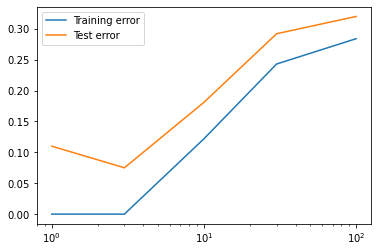

In [9]:
plt.plot(lam_list,train_error,label='Training error')
plt.plot(lam_list,test_error,label='Test error')
plt.xscale('log')
plt.legend()
plt.show()